# Team 7 Airline Delays EDA
## Bureau of Transportation Statistics
https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236   
https://www.bts.gov/topics/airlines-and-airports/understanding-reporting-causes-flight-delays-and-cancellations

2015 - 2019

## Additional sources
This might be useful in matching station codes to airports:
1. http://dss.ucar.edu/datasets/ds353.4/inventories/station-list.html
2. https://www.world-airport-codes.com/

# Data Pipeline Steps
> - Import raw data (Bronze)
>> - select columns
>> - filter
>> - join
>> - format dates
>> - fix schema (correct field types)
>> - handle Null/Corrupt Values
>> - handle outliers
> - Write to Disk (Gold)
> - Import Gold data
> - Split Data into Dev, Train, Test
> - Build end-to-end pipeline
> - Test for scale

# Feature Engineering & Model Selection
> - Define/Identify outcome variable
> - Feature Select (manual or automated?)
> - Create Feature Set (composite/aggregate columns)
> - Implement Feature Scaling
> - Select ML model

# Parallelization
> - Implement model in Spark 
> - Train, Test
> - Evaluate
> - Test baseline

# Performance fine-tuning 

# Innovation

# Visualization

# Data Pipeline Steps

* Imports
* Utilities
* Datasets
 * Bronze Datasets
   * airports_raw
   * airlines_raw
   * weather_raw
 * Silver Datasets
   * weather_silver
   * airlines_silver
 * Gold Datasets
   * airlines

## Imports

In [5]:
from pyspark.sql import functions as f
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, NullType, ShortType, DateType, BooleanType, BinaryType
from pyspark.sql import SQLContext
from pyspark.sql.functions import trim
import plotly.express as px
import urllib.request

sqlContext = SQLContext(sc)


## Utilities

In [9]:
# From https://forums.databricks.com/questions/20129/how-to-check-file-exists-in-databricks.html
def file_exists(path):
  try:
    dbutils.fs.ls(path)
    return True
  except Exception as e:
    if 'java.io.FileNotFoundException' in str(e):
      return False
    else:
      raise

# Environment

In [11]:
# Run validations: True | False
VALIDATE=False
# Verbose: True | False
VERBOSE=False
# Don't use persisted data on disk, instead recompute everything: True | False
FORCE_COMPUTE_ALL=True
# Persist everything to disk: True | False
PERSIST_ALL=False
# Datasets: 
# DATASETS='Toy' # Initial dev data
# DATASETS='2015' # All of 2015
DATASETS='2015_2017' # Years 2015-2017 inclusive

# Set the EDA sample percentage
SAMPLE_PERCENT = 0.001

# Datasets

## Bronze Datasets 
Bronze datasets will be named as follows:
* airports_raw
* weather_raw
* airlines_raw

In this first section, we will establish RDDs and SQL tables with those names. 

There is no need to persist the bronze tables since they are just views of raw data.

###airports_raw (airports.dat)

TODO: write up source of airports.dat

In [15]:
# FUNCTION TO SCRAPE AIRPORTS DATA
def init_airports_raw():
  # Note: the airports.dat data is very small, so we will always load it in full
  source_url = 'https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat'
  data_file_name = 'dbfs:/team7/data/airports.dat'
  if not file_exists(data_file_name):
    print(f"Importing the data from {source_url}")
    urllib.request.urlretrieve("https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat", "/tmp/airports.dat") 
    dbutils.fs.mv("file:/tmp/airports.dat", data_file_name)
  else:
    print(f"Skipping import: data already exists at {data_file_name}")
  # display(dbutils.fs.ls("/data/airports.dat"))
  airports_schema = StructType([
    StructField("Airport_ID", IntegerType(), True),
    StructField("Name", StringType(), True),
    StructField("City", StringType(), True),
    StructField("Country", StringType(), True),
    StructField("IATA", StringType(), True),
    StructField("ICAO", StringType(), True),
    StructField("Latitude", DoubleType(), True),
    StructField("Longitude", DoubleType(), True),
    StructField("Altitude", IntegerType(), True),
    StructField("Timezone", DoubleType(), True),
    StructField("DST", StringType(), True),
    StructField("Tz", StringType(), True),
    StructField("Type", StringType(), True),
    StructField("Source", StringType(), True)
  ])
  df = spark.read.format("csv") \
    .option("inferSchema", "false") \
    .option("header", "false") \
    .option("sep", ",") \
    .schema(airports_schema) \
    .load(data_file_name)
  return df

In [16]:
# SCRAPE AIRPORTS DATA
airports_raw = init_airports_raw()
airports_raw.createOrReplaceTempView("airports_raw")

Skipping import: data already exists at dbfs:/team7/data/airports.dat

In [17]:
def validate_airports_raw():
  # VERIFY (count=1)  
  kdmn_count = airports_raw.filter("ICAO == 'KDMN'").count()
  print(f"airports with ICAO == 'KDMN': {kdmn_count}")
  # FILTER AIRPORTS DATA
  # extract US airports
  airports_us = airports_raw.filter((f.col('country') == 'United States'))
  airports_us.count()
  print(f"number of us airports: {airports_us.count()}")
  
if VALIDATE:
  validate_airports_raw()  

In [18]:
# PRINT AIRPORTS SCHEMA
if VERBOSE :
  airports_raw.printSchema()

###Long Holidays 
(Via https://docs.google.com/spreadsheets/d/1zv-Sydffde6luh_lVTcFidjpjsK7ojjXRciAUelbQr4/edit#gid=749082549)

In [20]:
# need to clean up holidays CSV file?
# dbutils.fs.rm('dbfs:/team7/data/holidays.csv')

In [21]:
import requests
from pyspark.sql.functions import lit

# FUNCTION TO SCRAPE Long-Holidays DATA
def init_holidays_raw():
    # Note: the airports.dat data is very small, so we will always load it in full
    source_url = 'https://docs.google.com/spreadsheet/ccc?key=1zv-Sydffde6luh_lVTcFidjpjsK7ojjXRciAUelbQr4&output=csv'
    data_file_name = 'dbfs:/team7/data/holidays.csv'
    if not file_exists(data_file_name):
        print(f"Importing the data from {source_url}")
        response = requests.get(source_url) 
        assert response.status_code == 200, 'Wrong status code'
        dbutils.fs.put(data_file_name, str(response.content, 'utf-8'), True)
    else:
        print(f"Skipping import: data already exists at {data_file_name}")
        
    holidays_schema = StructType([
        StructField("Year", IntegerType(), True),
        StructField("Date", StringType(), True),
        StructField("Weekday", StringType(), True),
        StructField("Name", StringType(), False),
        StructField("Type", StringType(), False),
        ])
    
    df = spark.read.format("csv") \
        .option("inferSchema", "false") \
        .option("header", "true") \
        .option("sep", ",") \
        .schema(holidays_schema) \
        .load(data_file_name)
    
    date_split = f.split(df.Date, '/')

    return (df
            .withColumn("holiday", lit(1))
           )

In [22]:
# SCRAPE Long Holiday DATA
holidays_raw = init_holidays_raw()
holidays_raw.createOrReplaceTempView("holidays_raw")

Skipping import: data already exists at dbfs:/team7/data/holidays.csv

In [23]:
display(holidays_raw)

Year,Date,Weekday,Name,Type,holiday
2015,2015-01-01,Thursday,New Year's Day,Federal Holiday,1
2015,2015-01-02,Friday,null,null,1
2015,2015-01-03,Saturday,null,null,1
2015,2015-01-04,Sunday,null,null,1
2015,2015-01-17,Saturday,null,null,1
2015,2015-01-18,Sunday,null,null,1
2015,2015-01-19,Monday,Martin Luther King Jr. Day,Federal Holiday,1
2015,2015-02-14,Saturday,null,null,1
2015,2015-02-15,Sunday,null,null,1
2015,2015-02-16,Monday,Presidents' Day,Federal Holiday,1


### airlines_raw

In [26]:
def init_airlines_raw():
  if DATASETS == 'Toy':
    airlines_raw = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/data/datasets_final_project/parquet_airlines_data_3m/*.parquet")
  elif DATASETS == '2015':
    airlines_raw = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/data/datasets_final_project/parquet_airlines_data/2015.parquet")
  elif DATASETS == '2015_2017':
    airlines_raw = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/data/datasets_final_project/parquet_airlines_data/201[5-7].parquet")
  else:
    raise RuntimeException(f"Bad value for {DATASETS}")
  return airlines_raw

airlines_raw = init_airlines_raw()
# # FILTER DATA
# # extract airlines data for a given set of airport codes (ORD, ATL) and timeframe (2015 1st quarter) and for the given set of airports (ORD, ATL)
# filtered_airlines_yr = airlines_raw.filter(f.col('YEAR') == 2015)
# filtered_airlines_qtr = filtered_airlines_yr.filter(f.col('QUARTER') == 1)
# airlines_raw = filtered_airlines_qtr.filter((f.col('ORIGIN') == 'ATL') | (f.col('ORIGIN') == 'ORD'))
airlines_raw.createOrReplaceTempView("airlines_raw")


In [29]:
# join with airlines and holidays
def join_longHolidays_toAirlines(airlinesDF, holidaysDF):
    df = (holidaysDF.select("holiday","Date")
                  .withColumnRenamed("Date","FL_Date")
          .join(airlinesDF, on="FL_Date", how="right") )
    
    return df.fillna({'holiday':0})

airlines_raw = join_longHolidays_toAirlines(airlines_raw,holidays_raw)

In [30]:
if VERBOSE :
   airlines_raw.printSchema()

# Airlines Delay Schedule EDA

In [32]:
# Run to install calmap
!pip install calmap


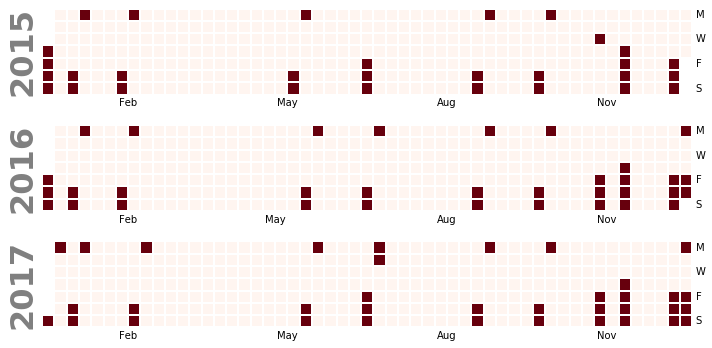

In [33]:
# Display 2015-2017 long holidays on calendar and 
# compare to delays

import numpy as np; np.random.seed(sum(map(ord, 'calmap')))
import pandas as pd
import calmap

# Grab our Holidays data to plot as reference
holiays_subset = (airlines_raw
                        .select("FL_Date","holiday")
                        .distinct().toPandas()
                     )

holiays_subset["FL_Date"] = pd.to_datetime(holiays_subset["FL_Date"])
events = pd.Series(np.asarray(holiays_subset["holiday"]), index=pd.to_datetime(holiays_subset["FL_Date"]))

calmap.calendarplot(events, monthticks=3, daylabels='MTWTFSS',
                    dayticks=[0, 2, 4, 6], # cmap='YlGn',
                    fillcolor='grey', linewidth=1,
                    fig_kws=dict(figsize=(10, 5)))

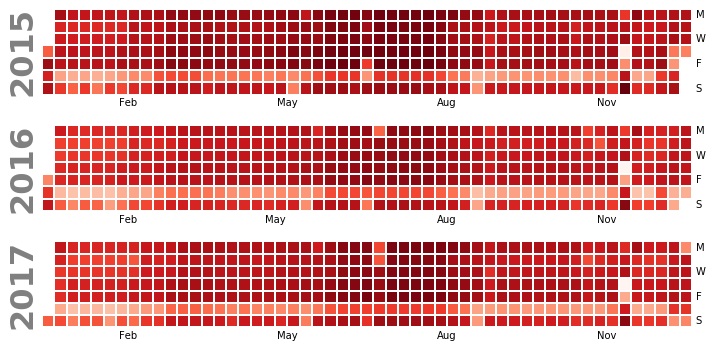

In [34]:
# Comparing delays across the training data to our holiday feature
dailydelay15_subset = (airlines_raw
                            .select("FL_Date","DEP_DEL15")
                            .groupby("FL_Date").agg({"*": "count"})
                            .withColumnRenamed("count(1)","DailyDelays")
                            .toPandas()
                          )

if VERBOSE :
   display(dailydelay15_subset)

# convert strings into date format
dailydelay15_subset["FL_Date"] = pd.to_datetime(dailydelay15_subset["FL_Date"])
events = pd.Series(np.asarray(dailydelay15_subset["DailyDelays"]), index=pd.to_datetime(dailydelay15_subset["FL_Date"]))

calmap.calendarplot(events, monthticks=3, daylabels='MTWTFSS',
                    dayticks=[0, 2, 4, 6], # cmap='YlGn',
                    fillcolor='grey', linewidth=1,
                    fig_kws=dict(figsize=(10, 5)))

In [35]:
# Noticed a late day in Nov each year that has one of the lowest number of delays, validate
if VALIDATE :
  display(  (airlines_raw
                .select("FL_Date","DEP_DEL15")
                .groupby("FL_Date").agg({"*": "count"})
                .withColumnRenamed("count(1)","DailyDelays")
                .sort(col("DailyDelays"))
            )
         )


In [36]:
# Delays by YEAR, QUARTER
query = f"""
       WITH delay_counts AS 
       (
        select YEAR, 
               QUARTER, 
               count(*) as count
        from airlines_raw
        where DEP_DEL15 = 1
        group by YEAR, QUARTER
       )
      select YEAR as Year,
             QUARTER as Quarter, 
             count 
      from delay_counts
      order by Year, Quarter
       """

df = spark.sql(query)
display(df.withColumn('YEAR-QUARTER', f.concat(f.col('Year'),f.lit('-Q'), f.col('Quarter'))))

Year,Quarter,count,YEAR-QUARTER
2015,1,277851,2015-Q1
2015,2,286563,2015-Q2
2015,3,264891,2015-Q3
2015,4,228249,2015-Q4
2016,1,213444,2016-Q1
2016,2,240133,2016-Q2
2016,3,276010,2016-Q3
2016,4,223956,2016-Q4
2017,1,240282,2017-Q1
2017,2,294020,2017-Q2


In [37]:
# Delays by Delay Duration
query = f"""
         select YEAR, QUARTER, DEP_DELAY_GROUP, count(*) as tot_count
         from airlines_raw
         where DEP_DELAY_GROUP in (1,2,3,4) and year != '2019'
         group by YEAR, QUARTER, DEP_DELAY_GROUP
         order by YEAR,QUARTER, DEP_DELAY_GROUP      
       """

df = spark.sql(query)
display(df.withColumn('YEAR-QUARTER', f.concat(f.col('Year'),f.lit('-Q'), f.col('Quarter')))
          .select('YEAR', 'QUARTER', 'DEP_DELAY_GROUP', 'tot_count')
       )


YEAR,QUARTER,DEP_DELAY_GROUP,tot_count
2015,1,1,106667
2015,1,2,54518
2015,1,3,32736
2015,1,4,21493
2015,2,1,106393
2015,2,2,53589
2015,2,3,33036
2015,2,4,22283
2015,3,1,98281
2015,3,2,50680


In [38]:
# Delays by Delay Type 
query = f"""
       select YEAR, 
              QUARTER, 
              count(*) as tot_flights,
              sum(DEP_DELAY) as tot_delay,
              sum(WEATHER_DELAY) as weather_delay, 
              sum(NAS_DELAY) as nas_delay,
              sum(SECURITY_DELAY) as security_delay,
              sum(LATE_AIRCRAFT_DELAY) as late_aircraft_delay,
              sum(CARRIER_DELAY) as carrier_delay
      from airlines_raw
      group by YEAR, QUARTER
      
       """

df = spark.sql(query)
display(df.withColumn('YEAR-QUARTER', f.concat(f.col('Year'),f.lit('-Q'), f.col('Quarter')))
          .withColumn('extreme_weather%', f.col('weather_delay')*100./f.col('tot_delay'))
          .withColumn('NAS%', f.col('nas_delay')*100./f.col('tot_delay'))
          .withColumn('carrier%', f.col('carrier_delay')*100./f.col('tot_delay'))
          .withColumn('late_aircraft%', f.col('late_aircraft_delay')*100./f.col('tot_delay'))
          .withColumn('security%', f.col('security_delay')*100./f.col('tot_delay'))
          .select('YEAR-QUARTER','extreme_weather%','NAS%', 'carrier%', 'late_aircraft%', 'security%')
         .orderBy('YEAR-QUARTER' )
       )


YEAR-QUARTER,extreme_weather%,NAS%,carrier%,late_aircraft%,security%
2015-Q1,6.402145361347338,27.338972055711334,37.14676157491927,46.068359465006715,0.12666565046774692
2015-Q2,6.141254264269309,26.188376435225234,35.68175586112991,45.87928592099059,0.10763698646266204
2015-Q3,4.835156789474097,25.912291902965794,38.18917117219006,47.278446711123316,0.1886105615064734
2015-Q4,5.569698668121949,27.45562082572953,39.87585407311362,46.82498669194638,0.19560492310827862
2016-Q1,5.595694423429331,30.76181890015299,40.62993377564417,46.82423417103399,0.16972570308929819
2016-Q2,5.5419807689800855,27.26687749953732,39.570294833625994,49.209501278605686,0.179168362880739
2016-Q3,5.244609946068232,27.66857866967482,37.47068703855391,45.63193123764545,0.15885055717043178
2016-Q4,4.605040992427991,29.124108883567782,40.64562127436436,47.90756723697084,0.1541099593264674
2017-Q1,5.366015693974671,31.142416026052683,38.619888892507845,47.70419568281235,0.12021148325260744
2017-Q2,4.835985100054864,30.216063642401316,34.18397957972328,46.2623576087669,0.10855949321485979


# Weather_raw
https://data.nodc.noaa.gov/cgi-bin/iso?id=gov.noaa.ncdc:C00532

In [42]:
# IMPORT WEATHER DATA
def init_weather_raw():
  print("Loading weather")
  if DATASETS == 'Toy':
    df = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/data/datasets_final_project/weather_data/weather2015a.parquet")

    # FILTER WEATHER DATA
    # extract weather data for US
    # weather = weather.filter(f.col('name').contains(', US'))

    # extract weather data for the 1st quarter of 2015
    df = df.filter(f.col('date').between("2015-01-01", "2015-04-01"))
  elif DATASETS == '2015':
    df = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/data/datasets_final_project/weather_data/weather2015a.parquet")
  elif DATASETS == '2015_2017':
    df = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/data/datasets_final_project/weather_data/weather201[5-7]a.parquet")
  else:
    raise RuntimeException(f"Bad value for {DATASETS}")
  return df


In [43]:
weather_raw = init_weather_raw()
weather_raw.createOrReplaceTempView("weather_raw")

Loading weather

# Weather EDA

- take 1% sample

In [45]:
def validate_weather_raw():
  # VERIFY IMPORT
  # # display US airports with valid call sign values 
  # display(weather_raw.filter((f.col('report_type') == 'FM-15') & (f.col('call_sign') != '99999')))
  # display number of unique valid call signs (2150)
  tmp = (weather_raw.filter((f.col('report_type') == 'FM-15') & (f.col('call_sign') != '99999')))
  tmp.select(f.countDistinct("call_sign")).show()

if VALIDATE:
  validate_weather_raw()

In [46]:
query = f"""
    WITH quarters AS (
    select date_trunc("QUARTER", DATE) as quarter, 
           count(*) as count
    from weather_raw
    group by quarter
    )
    select date_format(quarter, "yyyy") as Year,
           date_format(quarter, "q") as Quarter, 
           count from quarters
    order by Year, Quarter
"""
if VALIDATE:
  print(query)
  df = spark.sql(query)
  display(df)


In [47]:
# PRINT WEATHER SCHEMA
if VERBOSE :
  weather_raw.printSchema()

In [48]:
weather_raw_samp = weather_raw.sample(False, SAMPLE_PERCENT, 0).cache()
weather_raw_samp.createOrReplaceTempView("weather_raw_samp")

In [49]:
if VERBOSE :
  weather_raw_samp.count()

## Weather EDA Queries

In [52]:
# How many valid callsigns
query = f"""
    select count(*)
    from weather_raw
    where CALL_SIGN != "99999"
"""
if VERBOSE :
  print(query)
  df = spark.sql(query)
  display(df)


In [53]:
query = f"""
    select REPORT_TYPE, count(*) as Count
    from weather_raw
    group by REPORT_TYPE
    order by Count desc
"""
print(query)
df = spark.sql(query)
display(df)

REPORT_TYPE,Count
FM-15,184899033
FM-12,101390213
CRN05,47711072
FM-16,13708089
SAO,13221055
FM-14,4856151
SOD,1900109
SURF,168582
SHEF,54826
SOM,39226


In [55]:
query = f"""
    select cast(substring(CIG,1,5) as int) as Air_Ceiling, count(*) as Count
    from weather_raw_samp
    where CIG not like "999%"
    group by Air_Ceiling
    order by Air_Ceiling
"""
print(query)
df = spark.sql(query)
display(df)

Air_Ceiling,Count
0,251
8,1
9,1
10,2
12,1
18,2
20,5
22,1
26,1
30,1432


In [56]:
query = f"""
    select cast(substring(VIS,1,6) as int) as visibility, count(*) as Count
    from weather_raw_samp
    group by visibility
    order by visibility
"""
print(query)
df = spark.sql(query)
display(df)

visibility,Count
0,528
49,26
50,92
60,2
70,1
100,291
101,4
120,3
150,46
160,2


In [58]:
#Wind angle
# query = f"""
#     select distinct substring(WND,1,3) as windangle, count(*) as Count
#     from weather_raw_samp
#     where CALL_SIGN != "99999" and report_type = "FM-15"
#     group by windangle
#     order by windangle
# """
# print(query)
# df = spark.sql(query)
# display(df)

In [59]:
# How many are 999 wind speeds due to zero speed?

#Wind angle missing and speed = 0
query = f"""
    select count(*) as Count
    from weather_raw_samp
    where CALL_SIGN != "99999" and report_type = "FM-15" 
"""
print(query)
df = spark.sql(query)
display(df)

Count
98833


In [60]:
# How many are 999 wind speeds due to zero speed?
query = f"""
    select count(*) as Count
    from weather_raw_samp
    where CALL_SIGN != "99999" and report_type = "FM-15" 
          and substring(WND,1,3) = "999" and substring(WND,9,3) = 0
"""
print(query)
df = spark.sql(query)
display(df)

Count
20889


In [61]:
# Total wind angles measured code quality
query = f"""
    select distinct substring(WND,3,1) as windspeed_QCode, count(*) as Count
    from weather_raw_samp
    where CALL_SIGN != "99999" and report_type = "FM-15"
    group by windspeed_QCode
    order by windspeed_QCode
"""
print(query)
df = spark.sql(query)
display(df)

windspeed_QCode,Count
0,75038
5,4
9,23791


In [62]:
#Wind Speed range of values
query = f"""
    select distinct substring(WND,9,3) as windspeed, count(*) as Count
    from weather_raw_samp
    where CALL_SIGN != "99999" and report_type = "FM-15"
    group by windspeed
    order by windspeed
"""
print(query)
df = spark.sql(query)
display(df)

windspeed,Count
000,20977
001,9282
002,18496
003,15537
004,11643
005,8082
006,5249
007,3374
008,2083
009,1191


In [64]:
# Temp
query = f"""
    select round(cast(substring(TMP,2,4) as int)/10) as Temperature, count(*) as Count
      from weather_raw_samp
      where CALL_SIGN != "99999" and report_type = "FM-15" and TMP like "+%"
      group by Temperature
  union all
    select round(cast(substring(TMP,2,4) as int)/-10) as Temperature, count(*) as Count
      from weather_raw_samp
      where CALL_SIGN != "99999" and report_type = "FM-15" and TMP like "-%"
      group by Temperature
  order by Temperature
"""
print(query)
df = spark.sql(query)
display(df)

Temperature,Count
-49.0,1
-46.0,1
-43.0,1
-41.0,2
-40.0,10
-39.0,1
-38.0,4
-37.0,2
-36.0,7
-35.0,4


In [66]:
# Dew
query = f"""
  select round(cast(substring(DEW,2,4) as int)/10) as Dew_Point, count(*) as Count
      from weather_raw_samp
      where CALL_SIGN != "99999" and report_type = "FM-15" and DEW like "+%"
      group by Dew_Point
  union all
    select round(cast(substring(DEW,2,4) as int)/-10) as Dew_Point, count(*) as Count
      from weather_raw_samp
      where CALL_SIGN != "99999" and report_type = "FM-15" and DEW like "-%"
      group by Dew_Point
  order by Dew_Point

"""
print(query)
df = spark.sql(query)
display(df)

Dew_Point,Count
-61.0,1
-47.0,3
-46.0,1
-45.0,2
-44.0,1
-41.0,1
-39.0,3
-38.0,3
-37.0,2
-36.0,5


## EDA: Validation

In [68]:
# Number of missing values for temperature
query = f"""
    select count(*) as Count
    from weather_raw_samp
    where tmp like "%9999%" 
"""
print(query)
df = spark.sql(query)
display(df)

Count
6181


In [69]:
# Number of missing values for Dew point temperature
query = f"""
    select count(*) as Count
    from weather_raw_samp
    where dew like "%9999%" 
"""
print(query)
df = spark.sql(query)
display(df)

Count
56827


In [70]:
# Number of missing values for Wnd angle
query = f"""
    select count(*) as Count
    from weather_raw_samp
    where wnd like "999%" 
"""
print(query)
df = spark.sql(query)
display(df)

Count
101257


In [71]:
def validate_weather_silver():
  non_null_icao = (weather_silve.where(f.col("ICAO").isNotNull())).count()
  print(f"reports with non-null icao: {non_null_icao}")
  null_icao = (weather_silver.where(f.col("ICAO").isNull())).count()
  print(f"reports with null icao: {null_icao}")

if VALIDATE:
  validate_weather_silver()


# Airlines EDA

- take 1% sample

In [74]:
def validate_airlines_raw():
  print(f"airlines_raw.count() {airlines_raw.count()}")
  # VERIFY FILTERED DATA

if VALIDATE:
  validate_airlines_raw()


In [75]:
query = f"""
    WITH quarters AS (
      select YEAR, QUARTER, count(*) as count
      from airlines_raw
      group by YEAR, QUARTER
    )
    select YEAR as Year,
           QUARTER as Quarter, 
           count from quarters
    order by Year, Quarter
"""
if VALIDATE:
  print(query)
  df = spark.sql(query)
  display(df)


In [76]:
# Grab sample before next cells
airlines_raw_samp = airlines_raw.sample(False, SAMPLE_PERCENT, 0).cache()
airlines_raw_samp.createOrReplaceTempView("airlines_raw_samp")

In [77]:
if VERBOSE:
  airlines_raw_samp.count()

In [78]:
if VERBOSE:
  display(airlines_raw_samp)


## EDA Airline Delays by Day of week, Month

In [80]:
# Day of week delays from the sample
query = f"""
    select DAY_OF_WEEK, count(*) as Count
    from airlines_raw_samp
    where dep_del15 = 1
    group by DAY_OF_WEEK
    order by DAY_OF_WEEK
"""
print(query)
df = spark.sql(query)
display(df)

DAY_OF_WEEK,Count
1,488
2,406
3,405
4,501
5,485
6,308
7,429


In [81]:
# Monthly delays from our sample
query = f"""
    select Month, count(*) as Count
    from airlines_raw_samp
    where dep_del15 = 1
    group by Month
    order by Month
"""
print(query)
df = spark.sql(query)
display(df)

Month,Count
1,252
2,217
3,265
4,229
5,236
6,313
7,360
8,291
9,176
10,195


In [82]:
# Airport delays from 2015-2017
query = f"""
    select Origin, count(*) as Count
    from airlines_raw_samp
    where dep_del15 = 1
    group by Origin
    order by Count desc
"""
print(query)
df = spark.sql(query)
display(df)

Origin,Count
ATL,195
ORD,178
LAX,157
DFW,141
DEN,116
SFO,103
LAS,93
EWR,81
BOS,80
MCO,78


In [83]:
# Delays by hour, or (CRS_DEP_TIME%100) as Minute,
query = f"""
    select round((CRS_DEP_TIME/100)) as Hour, count(*) as Count
    from airlines_raw_samp
    where dep_del15 = 1
    group by Hour
    order by Hour
"""
print(query)
df = spark.sql(query)
display(df)

Hour,Count
0.0,3
1.0,6
2.0,2
5.0,17
6.0,78
7.0,90
8.0,99
9.0,118
10.0,142
11.0,197


## Silver Datasets
These have derived, cleaned and regularized data.
* weather_silver
* airlines_silver

#### NOTE: Times and Time buckets

We will convert all times to UTC and then bucket them as strings. A time bucket will be a string formated by the spark format string `yyyy-MM-dd HH:mm`

Initially, we will bucket by hour for convenience. So all buckets will look like 

* 2020-07-12 21:00
* 2020-07-12 22:00
* 2020-07-12 23:00
* 2020-07-12 00:00

All times greater or equal to the bucket name and strictly less than the next bucket name will fall in that bucket.

We may try finer granularity. For example, 15 minute buckets would look like this:

* 2020-07-12 21:00
* 2020-07-12 21:15
* 2020-07-12 21:30
* 2020-07-12 21:45

### weather_silver 
(weather_raw & airports_raw join based on ICAO)

In [88]:
def make_weather_silver(weatherdf, airportsDF):
    # Join join weather data call_sign with airports
    airport_codes = airportsDF.select("IATA", "ICAO").distinct()
    
    # pre-split wind and temp to handle missing values
    wind_split = f.split(weatherdf.WND, ',')
    tmp_split = f.split(weatherdf.TMP, ',')
    dew_split = f.split(weatherdf.DEW, ',')
    
    # Use funciton.when to perform some validation on incoming weather data
    # For ex: if wind angle is 0 due to zero wind speed set angle to 0.
    # Also applying scale refactoring as noted in the ISD documentation.
    df = ( weatherdf  
                .withColumn("CALL_SIGN", trim(weatherdf.CALL_SIGN))
                .withColumn("windangle", f.when(wind_split.getItem(3) == "0000", 0.)
                                          .otherwise(wind_split.getItem(0).cast("float")) )
                .withColumn("windspeed", f.split(weatherdf.WND, ',').getItem(3).cast("float") / 10.)
                .withColumn("TMP", tmp_split.getItem(0).cast("float") / 10.)
                .withColumn("DEW", dew_split.getItem(0).cast("float") / 10.)
                .withColumn("CIG", f.split(weatherdf.CIG, ',').getItem(0).cast("float"))
                .withColumn("VIS", f.split(weatherdf.VIS, ',').getItem(0).cast("float"))
                .withColumn("time_bucket", f.date_format(f.date_trunc("hour", "date"), "yyyy-MM-dd HH:mm"))
          
                # TODO: add missing flags for wind, windangle, tmp, dew
           )
    
    # update weather_raw with IATA, by joining weather_raw to airport_codes based on ICAO
    ## rename CALL_SIGN to ICAO to facilitate join
    ## add a time_bucket field to capture the hour
    ## select relevant columns from weather_raw to minimize working data 
    df = ( df.withColumnRenamed("CALL_SIGN", "ICAO")
                  .withColumnRenamed("DATE", "date")
                  .withColumnRenamed("NAME", "name")
                  .withColumnRenamed("windspeed", "wind")
                  .withColumnRenamed("CIG", "cig")
                  .withColumnRenamed("VIS", "vis")
                  .withColumnRenamed("TMP", "tmp")
                  .withColumnRenamed("DEW", "dew")
                  .withColumn("time_bucket", f.date_format(f.date_trunc("hour", "date"), "yyyy-MM-dd HH:mm"))
                  .select("time_bucket", "date", "name", "wind",  "windangle", "cig", "vis", "tmp", "dew", "LATITUDE", "LONGITUDE", "ELEVATION", "ICAO")
                  .join(airport_codes, on="ICAO", how="inner")
          )
    return df

In [89]:
# CREATE WEATHER_SILVER
weather_silver = make_weather_silver(weather_raw, airports_raw).cache()
weather_silver.createOrReplaceTempView("weather_silver")


## airlines_silver:

In [91]:
from pyspark.sql.functions import hour
# FUNCTION TO JOIN AIRLINES AND AIRPORTS DATA
def make_airlines_join_airports(airlinesDF, airportsDF):
  airport_codes_origin = airportsDF.select("IATA", "ICAO", "Tz").distinct()
  airport_codes_dest = airportsDF.select("IATA", "ICAO", "Tz").distinct()

  # add IACO and universal Tz for all origin aiports
  df = ( airlinesDF.withColumnRenamed("ORIGIN", "IATA")
        .join(airport_codes_origin, on="IATA", how="inner")
        .withColumnRenamed("IATA", "ORIGIN")
        .withColumnRenamed("ICAO", "origin_icao")
        .withColumnRenamed("Tz", "origin_time_zone")
     )
  
  # add IACO and universal Tz for all origin aiports
  df = ( df.withColumnRenamed("DEST", "IATA")
        .join(airport_codes_dest, on="IATA", how="inner")
        .withColumnRenamed("IATA", "DEST")
        .withColumnRenamed("ICAO", "dest_icao")
        .withColumnRenamed("Tz", "dest_time_zone")
     )
  
  # convert arrival and departure times to UTC format
  df = ( df
        .withColumn("crs_dep_time_utc", f.to_utc_timestamp(f.format_string("%s %02d:%02d", 
                                                    df.FL_DATE, 
                                                    (df.CRS_DEP_TIME / 100).cast(IntegerType()), 
                                                    df.CRS_DEP_TIME % 100), 
                                                     df.origin_time_zone))
        .withColumn("crs_arr_time_utc", f.to_utc_timestamp(f.format_string("%s %02d:%02d", 
                                                    df.FL_DATE, 
                                                    (df.CRS_ARR_TIME / 100).cast(IntegerType()), 
                                                    df.CRS_ARR_TIME % 100), 
                                                     df.origin_time_zone))
        .withColumn("dep_time_utc", f.to_utc_timestamp(f.format_string("%s %02d:%02d", 
                                                    df.FL_DATE, 
                                                    (df.DEP_TIME / 100).cast(IntegerType()), 
                                                    df.DEP_TIME % 100), 
                                                     df.origin_time_zone))
        .withColumn("arr_time_utc", f.to_utc_timestamp(f.format_string("%s %02d:%02d", 
                                                    df.FL_DATE, 
                                                    (df.ARR_TIME / 100).cast(IntegerType()), 
                                                    df.ARR_TIME % 100), 
                                                     df.origin_time_zone))
     )
  
  # add time_buckets to arrival and departure times as well as prediction time
  # add CRS_DEP_HOUR to ensure with FL_DATE it captures local time zone and local day of flight operations
  df = ( df  
        .withColumn("UTC_HOUR", hour(df.crs_dep_time_utc))
        .withColumn("CRS_DEP_HOUR", (df.CRS_DEP_TIME / 100).cast(IntegerType()))
        .withColumn("CRS_ARR_HOUR", (df.CRS_ARR_TIME / 100).cast(IntegerType()))        
        .withColumn("sch_dep_time_bucket", f.date_format(f.date_trunc("hour", df.crs_dep_time_utc), "yyyy-MM-dd HH:mm"))
        .withColumn("sch_arr_time_bucket", f.date_format(f.date_trunc("hour", df.crs_arr_time_utc), "yyyy-MM-dd HH:mm"))
        .withColumn("act_dep_time_bucket", f.date_format(f.date_trunc("hour", df.dep_time_utc), "yyyy-MM-dd HH:mm"))
        .withColumn("act_arr_time_bucket", f.date_format(f.date_trunc("hour", df.arr_time_utc), "yyyy-MM-dd HH:mm"))
        .withColumn("pred_time_bucket", f.date_format(f.date_trunc("hour", df.crs_dep_time_utc - f.expr("INTERVAL 2 HOUR")), "yyyy-MM-dd HH:mm"))
        .withColumn("future_sch_dep_time_bucket", f.date_format(f.date_trunc("hour", df.crs_dep_time_utc + f.expr("INTERVAL 2 HOUR")), "yyyy-MM-dd HH:mm"))
        .withColumn("future_sch_arr_time_bucket", f.date_format(f.date_trunc("hour", df.crs_arr_time_utc + f.expr("INTERVAL 2 HOUR")), "yyyy-MM-dd HH:mm"))
        .withColumn("future_arr_time_bucket", f.date_format(f.date_trunc("hour", df.arr_time_utc + f.expr("INTERVAL 2 HOUR")), "yyyy-MM-dd HH:mm"))
     )
  
  return df



In [92]:
def init_airlines_silver(force=FORCE_COMPUTE_ALL, persist=PERSIST_ALL):
  file_name = f"/team7/{DATASETS}/airlines_silver"
  if not force and file_exists(file_name):
    print(f"Reading airlines_silver from {file_name}")
    df = sqlContext.read.option("header", "true").parquet(file_name)
    return df
  print("Computing airlines_silver")
  df = make_airlines_join_airports(airlines_raw, airports_raw)
  if persist:
    print(f"Persisting airlines_silver to {file_name}")
    df.write.mode("overwrite").format("parquet").save(file_name)
  return df


In [93]:
# CREATE AIRLINES_SILVER
airlines_silver = init_airlines_silver()
airlines_silver.createOrReplaceTempView("airlines_silver")


Computing airlines_silver

In [94]:
def validate_airlines_silver():
  # VERIFY AIRLINES_SILVER
  print(f"airlines_silver.count() {airlines_silver.count()}")

if VALIDATE:
  validate_airlines_silver()

## Silver (joined) Dataset

In [96]:
# FUNCTION TO JOIN AIRLINES AND WEATHER 
def make_airlines_join_weather(airlinesDF, weatherDF):
  # so we may get some flights with null weather and we may get some flights with more than one weather
  # we will probably want to aggregate somehow
  
  # join airlines_silver and weather_silver on origin airport (origin_icao) and prediction time bucket (time_bucket)
  join_columns = ["ICAO","time_bucket"]
   
  # join airlines and weather data on origin airport 
  df = ( airlinesDF
        .withColumnRenamed("origin_icao", "ICAO")
        .withColumnRenamed("pred_time_bucket", "time_bucket")
        .join(weatherDF, join_columns, how="left")
       )
  return df



In [97]:
# SAVE SILVER DATASET TO DISK

gold_data_path = f"/team7/{DATASETS}/gold_dataset_MR"
# dbutils.fs.rm(f"dbfs:" + gold_data_path, True) # uncomment to overwrite existing gold data

def persist_gold(df):
  # SAVE GOLD DATASET TO DISK
  (df.write.mode("overwrite").format("parquet").save(gold_data_path))

def init_gold_from_disk():
  # IMPORT GOLD DATA FROM DISK
  df = sqlContext.read.option("header", "true").parquet(f"dbfs:" + gold_data_path)
  return df


if not FORCE_COMPUTE_ALL and file_exists(gold_data_path):
  gold_df = init_gold_from_disk()
  print("Gold data already exists at {}!".format(gold_data_path))
else:
  # CREATE GOLD DATASET
  gold_df = make_airlines_join_weather(airlines_silver, weather_silver)
  if PERSIST_ALL:
    print("writing gold data to disk")
    persist_gold(gold_df)

silver_df = make_airlines_join_weather(airlines_silver, weather_silver)
silver_df.createOrReplaceTempView("silver_df")


# EDA: Delays by Airport

In [100]:
from pyspark.sql.functions import col

# Now that we've joined weathers LAT and Long we can map airports by their delay totals
delays_airportsample = (silver_df
                            .select("ORIGIN", "DEP_DEL15")
                            .groupby("ORIGIN").agg({"*": "count"})
                            .withColumnRenamed("count(1)","AirportDelays")
                                  .join(silver_df.select("ORIGIN","LATITUDE", "LONGITUDE")
                                                  .filter(silver_df.LATITUDE.isNotNull())
                                                  .filter(silver_df.LONGITUDE.isNotNull())
                                                  .distinct(),
                                        on="ORIGIN", how="left")
                            .sort(col("AirportDelays").desc())
                            .toPandas()
                          )

if VERBOSE :
  display(delays_airportsample)

In [101]:
# Display a range afte taking square root of total delays per airport, for debugging purposes
if VERBOSE :
  delays_airportsample['AirportDelays'].pow(1./2).describe()


In [102]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np

fig = go.Figure()

# Scale the square of the total delays per airport
scaleFactor = 0.07
sizes = np.sqrt(np.asarray(delays_airportsample['AirportDelays'])) * scaleFactor

fig.add_trace(go.Scattergeo(
    locationmode = 'USA-states',
    lon = delays_airportsample['LONGITUDE'],
    lat = delays_airportsample['LATITUDE'],
    hoverinfo = 'text',
    text = delays_airportsample['ORIGIN'],
    mode = 'markers',
    marker = dict(
        size = sizes,
        color = 'rgba(255, 0, 0, 0.3)',
        line = dict(
            width = 3,
            color = 'rgba(68, 68, 68, 0)'
        )
    )))

   
fig.update_layout(
    title_text = 'Delays by Airport (hover mouse for names)',
    showlegend = True,
    geo = dict(
        scope = 'north america',
        projection_type = 'azimuthal equal area',
        showland = True,
        landcolor = 'rgb(243, 243, 243)',
        countrycolor = 'rgb(204, 204, 204)',
    ),
    height=900,
)

fig.show()

#Model Building

# Feature Engineering

### 1. Encode ORIGIN-DEST path

In [107]:
# add a column that strings together ORIGIN and DEST
from pyspark.sql.functions import udf, concat, lit, col
silver_df = silver_df.withColumn("ORIGIN-DEST", concat(col("ORIGIN"),lit('-'), col("DEST")))
display(silver_df.select("ORIGIN-DEST")) # display the added column

ORIGIN-DEST
ABE-ATL
ABE-DTW
ABE-ATL
ABE-ORD
ABE-ATL
ABE-ORD
ABE-ATL
ABE-DTW
ABE-DTW
ABE-DTW


### 2. Expected departure delay time  across all flights that departed BEFORE prediction period

In [109]:
print(silver_df.columns)

['ICAO', 'time_bucket', 'DEST', 'ORIGIN', 'FL_DATE', 'holiday', 'YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIER', 'OP_CARRIER_AIRLINE_ID', 'OP_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM', 'ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN_CITY_MARKET_ID', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR', 'ORIGIN_STATE_FIPS', 'ORIGIN_STATE_NM', 'ORIGIN_WAC', 'DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID', 'DEST_CITY_MARKET_ID', 'DEST_CITY_NAME', 'DEST_STATE_ABR', 'DEST_STATE_FIPS', 'DEST_STATE_NM', 'DEST_WAC', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'DEP_DELAY_NEW', 'DEP_DEL15', 'DEP_DELAY_GROUP', 'DEP_TIME_BLK', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'ARR_DELAY_NEW', 'ARR_DEL15', 'ARR_DELAY_GROUP', 'ARR_TIME_BLK', 'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'FLIGHTS', 'DISTANCE', 'DISTANCE_GROUP', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'FIRST_DEP_TIME', 'TOTAL_ADD_GTIME', 'LONGEST_ADD_GTIME', 'DIV_AIRPORT_LANDINGS', 'DIV_REACHED_DEST', 'DIV_ACTUAL_ELAPSED_TIME', 'DIV_ARR_DELAY', 'DIV_DISTANCE', 'DIV1_AIRPORT', 'DIV1_AIRPORT_ID', 'DIV1_AIRPORT_SEQ_ID', 'DIV1_WHEELS_ON', 'DIV1_TOTAL_GTIME', 'DIV1_LONGEST_GTIME', 'DIV1_WHEELS_OFF', 'DIV1_TAIL_NUM', 'DIV2_AIRPORT', 'DIV2_AIRPORT_ID', 'DIV2_AIRPORT_SEQ_ID', 'DIV2_WHEELS_ON', 'DIV2_TOTAL_GTIME', 'DIV2_LONGEST_GTIME', 'DIV2_WHEELS_OFF', 'DIV2_TAIL_NUM', 'DIV3_AIRPORT', 'DIV3_AIRPORT_ID', 'DIV3_AIRPORT_SEQ_ID', 'DIV3_WHEELS_ON', 'DIV3_TOTAL_GTIME', 'DIV3_LONGEST_GTIME', 'DIV3_WHEELS_OFF', 'DIV3_TAIL_NUM', 'DIV4_AIRPORT', 'DIV4_AIRPORT_ID', 'DIV4_AIRPORT_SEQ_ID', 'DIV4_WHEELS_ON', 'DIV4_TOTAL_GTIME', 'DIV4_LONGEST_GTIME', 'DIV4_WHEELS_OFF', 'DIV4_TAIL_NUM', 'DIV5_AIRPORT', 'DIV5_AIRPORT_ID', 'DIV5_AIRPORT_SEQ_ID', 'DIV5_WHEELS_ON', 'DIV5_TOTAL_GTIME', 'DIV5_LONGEST_GTIME', 'DIV5_WHEELS_OFF', 'DIV5_TAIL_NUM', 'origin_time_zone', 'dest_icao', 'dest_time_zone', 'crs_dep_time_utc', 'crs_arr_time_utc', 'dep_time_utc', 'arr_time_utc', 'UTC_HOUR', 'CRS_DEP_HOUR', 'CRS_ARR_HOUR', 'sch_dep_time_bucket', 'sch_arr_time_bucket', 'act_dep_time_bucket', 'act_arr_time_bucket', 'future_sch_dep_time_bucket', 'future_sch_arr_time_bucket', 'future_arr_time_bucket', 'date', 'name', 'wind', 'windangle', 'cig', 'vis', 'tmp', 'dew', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'IATA', 'ORIGIN-DEST']

In [110]:
# display(silver_df)

In [111]:
# This code pulls out features with null values... right now all columns have nulls

# columns_with_nulls = []
# for feature in silver_df.columns:
#   distinct_values = [item[0] for item in silver_df.select(feature).distinct().collect()]
#   if None in distinct_values:
# #     print(feature)
#     columns_with_nulls.append(feature)
# print(columns_with_nulls)

columns_with_nulls = ['TAIL_NUM', 'DEP_TIME', 'DEP_DELAY', 'DEP_DELAY_NEW', 'DEP_DEL15', 'DEP_DELAY_GROUP', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'ARR_TIME', 'ARR_DELAY', 'ARR_DELAY_NEW', 'ARR_DEL15', 'ARR_DELAY_GROUP', 'CANCELLATION_CODE', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'FIRST_DEP_TIME', 'TOTAL_ADD_GTIME', 'LONGEST_ADD_GTIME', 'DIV_REACHED_DEST', 'DIV_ACTUAL_ELAPSED_TIME', 'DIV_ARR_DELAY', 'DIV_DISTANCE', 'DIV1_AIRPORT', 'DIV1_AIRPORT_ID', 'DIV1_AIRPORT_SEQ_ID', 'DIV1_WHEELS_ON', 'DIV1_TOTAL_GTIME', 'DIV1_LONGEST_GTIME', 'DIV1_WHEELS_OFF', 'DIV1_TAIL_NUM', 'DIV2_AIRPORT', 'DIV2_AIRPORT_ID', 'DIV2_AIRPORT_SEQ_ID', 'DIV2_WHEELS_ON', 'DIV2_TOTAL_GTIME', 'DIV2_LONGEST_GTIME', 'DIV2_WHEELS_OFF', 'DIV2_TAIL_NUM', 'DIV3_AIRPORT', 'DIV3_AIRPORT_ID', 'DIV3_AIRPORT_SEQ_ID', 'DIV3_WHEELS_ON', 'DIV3_TOTAL_GTIME', 'DIV3_LONGEST_GTIME', 'DIV3_WHEELS_OFF', 'DIV3_TAIL_NUM', 'DIV4_AIRPORT', 'DIV4_AIRPORT_ID', 'DIV4_AIRPORT_SEQ_ID', 'DIV4_WHEELS_ON', 'DIV4_TOTAL_GTIME', 'DIV4_LONGEST_GTIME', 'DIV4_WHEELS_OFF', 'DIV4_TAIL_NUM', 'DIV5_AIRPORT', 'DIV5_AIRPORT_ID', 'DIV5_AIRPORT_SEQ_ID', 'DIV5_WHEELS_ON', 'DIV5_TOTAL_GTIME', 'DIV5_LONGEST_GTIME', 'DIV5_WHEELS_OFF', 'DIV5_TAIL_NUM', 'dep_time_utc', 'arr_time_utc', 'act_dep_time_bucket', 'act_arr_time_bucket', 'date', 'name', 'wind', 'cig', 'vis', 'tmp', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'IATA']

# Feature Selection

In [113]:
# features of interest
silver_df_features = ['ICAO', 'time_bucket', 'DEST', 'ORIGIN', 'YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE', 'OP_UNIQUE_CARRIER', 'OP_CARRIER_AIRLINE_ID', 'OP_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM', 'ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN_CITY_MARKET_ID', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR', 'ORIGIN_STATE_FIPS', 'ORIGIN_STATE_NM', 'ORIGIN_WAC', 'DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID', 'DEST_CITY_MARKET_ID', 'DEST_CITY_NAME', 'DEST_STATE_ABR', 'DEST_STATE_FIPS', 'DEST_STATE_NM', 'DEST_WAC', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'DEP_DELAY_NEW', 'DEP_DEL15', 'DEP_DELAY_GROUP', 'DEP_TIME_BLK', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'ARR_DELAY_NEW', 'ARR_DEL15', 'ARR_DELAY_GROUP', 'ARR_TIME_BLK', 'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'FLIGHTS', 'DISTANCE', 'DISTANCE_GROUP', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'FIRST_DEP_TIME', 'TOTAL_ADD_GTIME', 'LONGEST_ADD_GTIME', 'DIV_AIRPORT_LANDINGS', 'DIV_REACHED_DEST', 'DIV_ACTUAL_ELAPSED_TIME', 'DIV_ARR_DELAY', 'DIV_DISTANCE', 'DIV1_AIRPORT', 'DIV1_AIRPORT_ID', 'DIV1_AIRPORT_SEQ_ID', 'DIV1_WHEELS_ON', 'DIV1_TOTAL_GTIME', 'DIV1_LONGEST_GTIME', 'DIV1_WHEELS_OFF', 'DIV1_TAIL_NUM', 'DIV2_AIRPORT', 'DIV2_AIRPORT_ID', 'DIV2_AIRPORT_SEQ_ID', 'DIV2_WHEELS_ON', 'DIV2_TOTAL_GTIME', 'DIV2_LONGEST_GTIME', 'DIV2_WHEELS_OFF', 'DIV2_TAIL_NUM', 'DIV3_AIRPORT', 'DIV3_AIRPORT_ID', 'DIV3_AIRPORT_SEQ_ID', 'DIV3_WHEELS_ON', 'DIV3_TOTAL_GTIME', 'DIV3_LONGEST_GTIME', 'DIV3_WHEELS_OFF', 'DIV3_TAIL_NUM', 'DIV4_AIRPORT', 'DIV4_AIRPORT_ID', 'DIV4_AIRPORT_SEQ_ID', 'DIV4_WHEELS_ON', 'DIV4_TOTAL_GTIME', 'DIV4_LONGEST_GTIME', 'DIV4_WHEELS_OFF', 'DIV4_TAIL_NUM', 'DIV5_AIRPORT', 'DIV5_AIRPORT_ID', 'DIV5_AIRPORT_SEQ_ID', 'DIV5_WHEELS_ON', 'DIV5_TOTAL_GTIME', 'DIV5_LONGEST_GTIME', 'DIV5_WHEELS_OFF', 'DIV5_TAIL_NUM', 'origin_time_zone', 'dest_icao', 'dest_time_zone', 'crs_dep_time_utc', 'crs_arr_time_utc', 'dep_time_utc', 'arr_time_utc', 'sch_dep_time_bucket', 'sch_arr_time_bucket', 'act_dep_time_bucket', 'act_arr_time_bucket', 'date', 'name', 'wind', 'cig', 'vis', 'tmp', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'IATA']

feature_list = ['YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE', 'OP_UNIQUE_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM', 'ORIGIN_AIRPORT_ID', 'ORIGIN', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR', 'ORIGIN_STATE_NM', 'DEST_AIRPORT_ID', 'DEST', 'DEST_CITY_NAME', 'DEST_STATE_ABR', 'DEST_STATE_NM', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'DEP_DELAY_NEW', 'DEP_DEL15', 'DEP_DELAY_GROUP', 'DEP_TIME_BLK', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'ARR_DELAY_NEW', 'ARR_DEL15', 'ARR_DELAY_GROUP', 'ARR_TIME_BLK', 'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'DISTANCE_GROUP', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']

basic_feature_list = ['DEP_DELAY', 'DEP_DELAY_NEW','DEP_DEL15', 'DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY'] # 0.9348440705383061

# progressively used feature list and their ROC values

feature_list = ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE', 'OP_UNIQUE_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM', 'ORIGIN_AIRPORT_ID', 'ORIGIN', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR', 'ORIGIN_STATE_NM', 'DEST_AIRPORT_ID', 'DEST', 'DEST_CITY_NAME', 'DEST_STATE_ABR', 'DEST_STATE_NM', 'CRS_DEP_TIME', 'DEP_DELAY', 'DEP_DELAY_NEW', 'DEP_DEL15', 'DISTANCE', 'DISTANCE_GROUP'] #0.74.. 0.76 after converting to string

feature_list = ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE', 'OP_UNIQUE_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM', 'ORIGIN_AIRPORT_ID', 'ORIGIN', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR', 'ORIGIN_STATE_NM', 'DEST_AIRPORT_ID', 'DEST', 'DEST_CITY_NAME', 'DEST_STATE_ABR', 'DEST_STATE_NM', 'CRS_DEP_TIME', 'DEP_DELAY', 'DEP_DELAY_NEW', 'DEP_DEL15', 'DISTANCE', 'DISTANCE_GROUP', 'ORIGIN-DEST'] #0.75889 with last column addition

feature_list = ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE', 'OP_UNIQUE_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM', 'ORIGIN_AIRPORT_ID', 'ORIGIN', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR', 'ORIGIN_STATE_NM', 'DEST_AIRPORT_ID', 'DEST', 'DEST_CITY_NAME', 'DEST_STATE_ABR', 'DEST_STATE_NM', 'CRS_DEP_TIME', 'DEP_DELAY', 'DEP_DELAY_NEW', 'DEP_DEL15', 'DISTANCE', 'DISTANCE_GROUP', 'ORIGIN-DEST', 'sch_dep_time_bucket', 'sch_arr_time_bucket'] #0.7791742844526865

feature_list = ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE', 'OP_UNIQUE_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM', 'ORIGIN_AIRPORT_ID', 'ORIGIN', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR', 'ORIGIN_STATE_NM', 'DEST_AIRPORT_ID', 'DEST', 'DEST_CITY_NAME', 'DEST_STATE_ABR', 'DEST_STATE_NM', 'CRS_DEP_TIME', 'DEP_DELAY', 'DEP_DELAY_NEW', 'DEP_DEL15', 'DISTANCE', 'DISTANCE_GROUP', 'ORIGIN-DEST', 'sch_dep_time_bucket', 'sch_arr_time_bucket'] # 0.8468619442211929

feature_list = ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE', 'OP_UNIQUE_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM', 'ORIGIN_AIRPORT_ID', 'ORIGIN', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR', 'ORIGIN_STATE_NM', 'DEST_AIRPORT_ID', 'DEST', 'DEST_CITY_NAME', 'DEST_STATE_ABR', 'DEST_STATE_NM', 'CRS_DEP_TIME', 'DEP_DELAY', 'DEP_DELAY_NEW', 'DEP_DEL15', 'DISTANCE', 'DISTANCE_GROUP', 'ORIGIN-DEST', 'sch_dep_time_bucket', 'sch_arr_time_bucket', 'wind', 'windangle', 'cig', 'vis', 'tmp',] # 0.8859052624445102

In [114]:
def df_trim(old_df, feature_list, keep_features=True):
  """
  returns trimmed DF that only keeps (if True, else drops) columns in features_list
  
  Input: original dataframe, list of features, keep features=True will keep only these features
  Output: trimmed dataframe
  """

  if keep_features:
    del_feature_list = set(list(silver_df.columns)) - set(feature_list)
  else:
    del_feature_list = feature_list
    
  trimmed_df = old_df.drop(*del_feature_list) # drop all columns in del_feature_list
#   trimmed_df = trimmed_df.na.drop(subset=["DEP_DELAY"]) # drop rows that have nulls in DEP_DELAY
  return trimmed_df

silver_df_trimmed = df_trim(silver_df, feature_list, True)
silver_df_trimmed.createOrReplaceTempView("silver_df_trimmed")

### Aggregate feature generation (departure and arrival) from the silver dataset

In [117]:
# evaluate hourly departure aggregates
def hourly_dep_aggregates(verbose=True):
  """
  Aggregate features by hour
  
  input: silver_df
  output: df with hourly aggregates count_CRS_DEP_TIME, 
  count_DEP_TIME, sum_DEP_DELAY, sum_DEP_DELAY_NEW, 
  sum_DEP_DEL15, sum_TAXI_OUT, count_CANCELLED, 
  sum_CARRIER_DELAY, sum_WEATHER_DELAY, sum_NAS_DELAY,
  sum_SECURITY_DELAY, sum_LATE_AIRCRAFT_DELAY
  """
  
  table_name = 'silver_df'
  query = f"""
    select ORIGIN, 
           MONTH,
           DAY_OF_MONTH,
           FL_DATE,
           CRS_DEP_HOUR,
           sch_dep_time_bucket, 
           count(CRS_DEP_TIME) as count_CRS_DEP_TIME, 
           count(DEP_TIME) as count_DEP_TIME, 
           sum(DEP_DELAY) as agg_DEP_DELAY, 
           sum(DEP_DELAY_NEW) as agg_DEP_DELAY_NEW, 
           sum(DEP_DEL15) as agg_DEP_DEL15, 
           sum(TAXI_OUT) as agg_TAXI_OUT, 
           sum(CANCELLED) as count_CANCELLED, 
           sum(CARRIER_DELAY) as agg_CARRIER_DELAY, 
           sum(WEATHER_DELAY) as agg_WEATHER_DELAY, 
           sum(NAS_DELAY) as agg_NAS_DELAY, 
           sum(SECURITY_DELAY) as agg_SECURITY_DELAY, 
           sum(LATE_AIRCRAFT_DELAY) as agg_LATE_AIRCRAFT_DELAY
         from {table_name}
       group by ORIGIN, MONTH, DAY_OF_MONTH, FL_DATE, CRS_DEP_HOUR, sch_dep_time_bucket 
     order by ORIGIN, MONTH, DAY_OF_MONTH, FL_DATE, CRS_DEP_HOUR, sch_dep_time_bucket
  """
  if verbose:
    print(query)
  df = spark.sql(query)
  return df

hourly_dep_aggs_df = hourly_dep_aggregates()
hourly_dep_aggs_df.createOrReplaceTempView("hourly_dep_aggs_df")

select ORIGIN, 
 MONTH,
 DAY_OF_MONTH,
 FL_DATE,
 CRS_DEP_HOUR,
 sch_dep_time_bucket, 
 count(CRS_DEP_TIME) as count_CRS_DEP_TIME, 
 count(DEP_TIME) as count_DEP_TIME, 
 sum(DEP_DELAY) as agg_DEP_DELAY, 
 sum(DEP_DELAY_NEW) as agg_DEP_DELAY_NEW, 
 sum(DEP_DEL15) as agg_DEP_DEL15, 
 sum(TAXI_OUT) as agg_TAXI_OUT, 
 sum(CANCELLED) as count_CANCELLED, 
 sum(CARRIER_DELAY) as agg_CARRIER_DELAY, 
 sum(WEATHER_DELAY) as agg_WEATHER_DELAY, 
 sum(NAS_DELAY) as agg_NAS_DELAY, 
 sum(SECURITY_DELAY) as agg_SECURITY_DELAY, 
 sum(LATE_AIRCRAFT_DELAY) as agg_LATE_AIRCRAFT_DELAY
 from silver_df
 group by ORIGIN, MONTH, DAY_OF_MONTH, FL_DATE, CRS_DEP_HOUR, sch_dep_time_bucket 
 order by ORIGIN, MONTH, DAY_OF_MONTH, FL_DATE, CRS_DEP_HOUR, sch_dep_time_bucket

In [118]:
# evaluate hourly arrival aggregates
def hourly_arr_aggregates(verbose=True):
  """
  Aggregate arrival features by hour
  
  input: silver_df
  output: df with hourly aggregates count_CRS_ARR_TIME, 
  count_ARR_TIME, sum_ARR_DELAY, sum_ARR_DELAY_NEW, 
  sum_ARR_DEL15, sum_TAXI_IN
  """
  
  table_name = 'silver_df'
  query = f"""
    select DEST, 
           MONTH,
           DAY_OF_MONTH,
           FL_DATE,
           CRS_ARR_HOUR,
           sch_arr_time_bucket, 
           count(CRS_ARR_TIME) as count_CRS_ARR_TIME, 
           count(ARR_TIME) as count_ARR_TIME, 
           sum(ARR_DELAY) as agg_ARR_DELAY, 
           sum(ARR_DELAY_NEW) as agg_ARR_DELAY_NEW, 
           sum(ARR_DEL15) as agg_ARR_DEL15, 
           sum(TAXI_IN) as agg_TAXI_IN
         from {table_name}
       group by DEST, MONTH, DAY_OF_MONTH, FL_DATE, CRS_ARR_HOUR, sch_arr_time_bucket 
     order by DEST, MONTH, DAY_OF_MONTH, FL_DATE, CRS_ARR_HOUR, sch_arr_time_bucket 
  """
    
  if verbose:
    print(query)
  df = spark.sql(query)
  return df

hourly_arr_aggs_df = hourly_arr_aggregates()
hourly_arr_aggs_df.createOrReplaceTempView("hourly_arr_aggs_df")

select DEST, 
 MONTH,
 DAY_OF_MONTH,
 FL_DATE,
 CRS_ARR_HOUR,
 sch_arr_time_bucket, 
 count(CRS_ARR_TIME) as count_CRS_ARR_TIME, 
 count(ARR_TIME) as count_ARR_TIME, 
 sum(ARR_DELAY) as agg_ARR_DELAY, 
 sum(ARR_DELAY_NEW) as agg_ARR_DELAY_NEW, 
 sum(ARR_DEL15) as agg_ARR_DEL15, 
 sum(TAXI_IN) as agg_TAXI_IN
 from silver_df
 group by DEST, MONTH, DAY_OF_MONTH, FL_DATE, CRS_ARR_HOUR, sch_arr_time_bucket 
 order by DEST, MONTH, DAY_OF_MONTH, FL_DATE, CRS_ARR_HOUR, sch_arr_time_bucket

In [119]:
if VERBOSE :
  display(hourly_dep_aggs_df)

### priors

In [121]:
# calculate prior for departure features
from pyspark.sql.window import Window
from pyspark.sql.functions import col, lag, lead

# FL_DATE and CRS_DEP_HOUR ensure that local 6am-midnight operations are grouped together. 
window_w_offset = (Window.partitionBy('ORIGIN', 'MONTH', 'DAY_OF_MONTH', 'FL_DATE').orderBy('CRS_DEP_HOUR'))

# capture 2hr priors
prior_dep_agg_df = (hourly_dep_aggs_df.withColumn('count_CRS_DEP_TIME', col('count_CRS_DEP_TIME'))
                                      .withColumn('prior_count_DEP_TIME', lag(col('count_DEP_TIME'), 2).over(window_w_offset))
                                      .withColumn('prior_agg_DEP_DEL15', lag(col('agg_DEP_DEL15'), 2).over(window_w_offset))
                                      .withColumn('prior_agg_DEP_DELAY', lag(col('agg_DEP_DELAY'), 2).over(window_w_offset))                    
                                      .withColumn('prior_agg_DEP_DELAY_NEW', lag(col('agg_DEP_DELAY_NEW'), 2).over(window_w_offset))
                                      .withColumn('prior_agg_TAXI_OUT', lag(col('agg_TAXI_OUT'), 2).over(window_w_offset))
                                      .withColumn('prior_count_CANCELLED', lag(col('count_CANCELLED'), 2).over(window_w_offset))
                                      .withColumn('prior_agg_CARRIER_DELAY', lag(col('agg_CARRIER_DELAY'), 2).over(window_w_offset))
                                      .withColumn('prior_agg_WEATHER_DELAY', lag(col('agg_WEATHER_DELAY'), 2).over(window_w_offset))
                                      .withColumn('prior_agg_NAS_DELAY', lag(col('agg_NAS_DELAY'), 2).over(window_w_offset))
                                      .withColumn('prior_agg_SECURITY_DELAY', lag(col('agg_SECURITY_DELAY'), 2).over(window_w_offset))
                                      .withColumn('prior_agg_LATE_AIRCRAFT_DELAY', lag(col('agg_LATE_AIRCRAFT_DELAY'), 2).over(window_w_offset))
                   )

prior_dep_agg_df.createOrReplaceTempView('prior_dep_agg_df')

In [122]:
# drop the (illegit) real-time aggregate features
prior_dep_agg_df = prior_dep_agg_df.drop("FL_DATE", 'CRS_DEP_HOUR', 'count_DEP_TIME', 'agg_DEP_DEL15', 'agg_DEP_DELAY', 'agg_DEP_DELAY_NEW', 'agg_TAXI_OUT', 'count_CANCELLED', 'agg_CARRIER_DELAY', 'agg_WEATHER_DELAY', 'agg_NAS_DELAY', 'agg_SECURITY_DELAY', 'agg_LATE_AIRCRAFT_DELAY')
prior_dep_agg_df.columns

Out[72]: ['ORIGIN',
 'MONTH',
 'DAY_OF_MONTH',
 'sch_dep_time_bucket',
 'count_CRS_DEP_TIME',
 'prior_count_DEP_TIME',
 'prior_agg_DEP_DEL15',
 'prior_agg_DEP_DELAY',
 'prior_agg_DEP_DELAY_NEW',
 'prior_agg_TAXI_OUT',
 'prior_count_CANCELLED',
 'prior_agg_CARRIER_DELAY',
 'prior_agg_WEATHER_DELAY',
 'prior_agg_NAS_DELAY',
 'prior_agg_SECURITY_DELAY',
 'prior_agg_LATE_AIRCRAFT_DELAY']

In [123]:
# calculate prior for arrival features
from pyspark.sql.window import Window
from pyspark.sql.functions import col, lag, lead

window_w_offset = (Window.partitionBy('DEST', 'MONTH', 'DAY_OF_MONTH', 'FL_DATE').orderBy('CRS_ARR_HOUR'))

prior_arr_agg_df = (hourly_arr_aggs_df.withColumn('count_CRS_ARR_TIME', col('count_CRS_ARR_TIME'))
                                      .withColumn('prior_count_ARR_TIME', lag(col('count_ARR_TIME'), 2).over(window_w_offset))
                                      .withColumn('prior_agg_ARR_DEL15', lag(col('agg_ARR_DEL15'), 2).over(window_w_offset))
                                      .withColumn('prior_agg_ARR_DELAY', lag(col('agg_ARR_DELAY'), 2).over(window_w_offset))                    
                                      .withColumn('prior_agg_ARR_DELAY_NEW', lag(col('agg_ARR_DELAY_NEW'), 2).over(window_w_offset))
                                      .withColumn('prior_agg_TAXI_IN', lag(col('agg_TAXI_IN'), 2).over(window_w_offset))
                   )

prior_arr_agg_df.createOrReplaceTempView('prior_arr_agg_df')

In [124]:
# drop the (illegit) real-time aggregate features
prior_arr_agg_df = prior_arr_agg_df.drop("FL_DATE", "CRS_ARR_HOUR", 'count_ARR_TIME', 'agg_ARR_DEL15', 'agg_ARR_DELAY', 'agg_ARR_DELAY_NEW', 'agg_TAXI_IN')
prior_arr_agg_df.columns

Out[74]: ['DEST',
 'MONTH',
 'DAY_OF_MONTH',
 'sch_arr_time_bucket',
 'count_CRS_ARR_TIME',
 'prior_count_ARR_TIME',
 'prior_agg_ARR_DEL15',
 'prior_agg_ARR_DELAY',
 'prior_agg_ARR_DELAY_NEW',
 'prior_agg_TAXI_IN']

### cumulative sums

In [126]:
# # evaluate cumulative features
# from pyspark.sql import Window
# from pyspark.sql import functions as F
# def cumulative_aggs(df):
#   """
#   Evaluates cumulative aggregates by hour
  
#   input: dataframe with hourly aggregates
#   output: dataframe with cumulative aggregates reset every day
#   """

#   windowval = (Window.partitionBy('ORIGIN', 'MONTH', 'DAY_OF_MONTH').orderBy('future_sch_dep_time_bucket')
#                .rangeBetween(Window.unboundedPreceding, 0)
#               )
  
#   df_w_cumsum = (df.withColumn('cum_count_CRS_DEP_TIME', F.sum('count_CRS_DEP_TIME').over(windowval))
#                    .withColumn('cum_count_DEP_TIME', F.sum('count_DEP_TIME').over(windowval))
#                    .withColumn('cum_sum_DEP_DELAY', F.sum('sum_DEP_DELAY').over(windowval))
#                    .withColumn('cum_sum_DEP_DELAY_NEW', F.sum('sum_DEP_DELAY_NEW').over(windowval))
#                    .withColumn('cum_sum_DEP_DEL15', F.sum('sum_DEP_DEL15').over(windowval))
#                    .withColumn('cum_sum_TAXI_OUT', F.sum('sum_TAXI_OUT').over(windowval))
#                    .withColumn('cum_count_CANCELLED', F.sum('count_CANCELLED').over(windowval))
#                    .withColumn('cum_sum_CARRIER_DELAY', F.sum('sum_CARRIER_DELAY').over(windowval))
#                    .withColumn('cum_sum_WEATHER_DELAY', F.sum('sum_WEATHER_DELAY').over(windowval))
#                    .withColumn('cum_sum_NAS_DELAY', F.sum('sum_NAS_DELAY').over(windowval))
#                    .withColumn('cum_sum_SECURITY_DELAY', F.sum('sum_SECURITY_DELAY').over(windowval))
#                    .withColumn('cum_sum_LATE_AIRCRAFT_DELAY', F.sum('sum_LATE_AIRCRAFT_DELAY').over(windowval))
#                 )
  
#   return df_w_cumsum

# hourly_aggs_df_w_cumsum = cumulative_aggs(hourly_aggs_df)
# display(hourly_aggs_df_w_cumsum)


# # evaluate arrivals cumulative features
# from pyspark.sql import Window
# from pyspark.sql import functions as F
# def cumulative_arr_aggs(df):
#   """
#   Evaluates arrival cumulative aggregates by hour
  
#   input: dataframe with hourly arrival aggregates
#   output: dataframe with arrival cumulative aggregates reset every day
#   """

#   windowval = (Window.partitionBy('DEST', 'MONTH', 'DAY_OF_MONTH').orderBy('future_sch_arr_time_bucket')
#                .rangeBetween(Window.unboundedPreceding, 0)
#               )
    
#   df_w_arr_cumsum = (df.withColumn('cum_count_CRS_ARR_TIME', F.sum('count_CRS_ARR_TIME').over(windowval))
#                    .withColumn('cum_count_ARR_TIME', F.sum('count_ARR_TIME').over(windowval))
#                    .withColumn('cum_sum_ARR_DELAY', F.sum('sum_ARR_DELAY').over(windowval))
#                    .withColumn('cum_sum_ARR_DELAY_NEW', F.sum('sum_ARR_DELAY_NEW').over(windowval))
#                    .withColumn('cum_sum_ARR_DEL15', F.sum('sum_ARR_DEL15').over(windowval))
#                    .withColumn('cum_sum_TAXI_IN', F.sum('sum_TAXI_IN').over(windowval))
#                 )
  
#   return df_w_arr_cumsum

# hourly_arr_aggs_df_w_cumsum = cumulative_arr_aggs(hourly_arr_aggs_df)
# display(hourly_arr_aggs_df_w_cumsum)

## join the hourly_dep/arr_aggs_df to silver_df_trimmed

In [128]:
silver_df_trimmed = df_trim(silver_df, feature_list, True)

# join departure aggregates
silver_df_trimmed = silver_df_trimmed.drop("FL_DATE")
silver_df_trimmed_w_dep_priors = silver_df_trimmed.join(prior_dep_agg_df, on=["ORIGIN", "MONTH", "DAY_OF_MONTH", "sch_dep_time_bucket"], how="left")
silver_df_trimmed_old = silver_df_trimmed # save silver_df_trimmed as silver_df_trimmed_old
silver_df_trimmed = silver_df_trimmed_w_dep_priors # reset silver_df_trimmed to the new enhanced version

In [129]:
# join arrival aggregates
# hourly_arr_aggs_df_w_cumsum = hourly_arr_aggs_df_w_cumsum.withColumnRenamed("future_sch_arr_time_bucket", "sch_arr_time_bucket") # reset the column name to facilitate joining
silver_df_trimmed_w_arr_priors = silver_df_trimmed.join(prior_arr_agg_df, on=["DEST", "MONTH", "DAY_OF_MONTH", "sch_arr_time_bucket"], how="left")
silver_df_trimmed_old = silver_df_trimmed # save silver_df_trimmed as silver_df_trimmed_old
silver_df_trimmed = silver_df_trimmed_w_arr_priors # reset silver_df_trimmed to the new enhanced version
silver_df_trimmed.createOrReplaceTempView("silver_df_trimmed")
silver_df_trimmed_old.createOrReplaceTempView("silver_df_trimmed_old")

In [130]:
if VERBOSE :
  display(silver_df_trimmed)

In [131]:
if VERBOSE :
  silver_df_trimmed.columns

## type conversion

In [133]:
# identify all categorical columns and convert them to string
categorical_columns = ['ICAO', 'DEST', 'ORIGIN', 'OP_UNIQUE_CARRIER', 'OP_CARRIER_AIRLINE_ID', 'OP_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM', 'ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN_CITY_MARKET_ID', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR', 'ORIGIN_STATE_FIPS', 'ORIGIN_STATE_NM', 'ORIGIN_WAC', 'DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID', 'DEST_CITY_MARKET_ID', 'DEST_CITY_NAME', 'DEST_STATE_ABR', 'DEST_STATE_FIPS', 'DEST_STATE_NM', 'DEST_WAC', 'DEP_DELAY_GROUP', 'ARR_DELAY_GROUP', 'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED','DISTANCE_GROUP', 'dest_icao', 'dest_time_zone', 'IATA']

from pyspark.sql.functions import expr, col, column

for cat_feature in categorical_columns:
  if cat_feature in silver_df_trimmed.columns:
    silver_df_trimmed = (silver_df_trimmed.withColumn(cat_feature, col(cat_feature).cast("string")))

silver_df_trimmed.printSchema()
silver_df_trimmed.createOrReplaceTempView("silver_df_trimmed")

root
-- DEST: string (nullable = true)
-- MONTH: integer (nullable = true)
-- DAY_OF_MONTH: integer (nullable = true)
-- sch_arr_time_bucket: string (nullable = true)
-- ORIGIN: string (nullable = true)
-- sch_dep_time_bucket: string (nullable = true)
-- DAY_OF_WEEK: integer (nullable = true)
-- OP_UNIQUE_CARRIER: string (nullable = true)
-- TAIL_NUM: string (nullable = true)
-- OP_CARRIER_FL_NUM: string (nullable = true)
-- ORIGIN_AIRPORT_ID: string (nullable = true)
-- ORIGIN_CITY_NAME: string (nullable = true)
-- ORIGIN_STATE_ABR: string (nullable = true)
-- ORIGIN_STATE_NM: string (nullable = true)
-- DEST_AIRPORT_ID: string (nullable = true)
-- DEST_CITY_NAME: string (nullable = true)
-- DEST_STATE_ABR: string (nullable = true)
-- DEST_STATE_NM: string (nullable = true)
-- CRS_DEP_TIME: integer (nullable = true)
-- DEP_DELAY: double (nullable = true)
-- DEP_DELAY_NEW: double (nullable = true)
-- DEP_DEL15: double (nullable = true)
-- DISTANCE: double (nullable = true)
-- DISTANCE_GROUP: string (nullable = true)
-- wind: double (nullable = true)
-- windangle: double (nullable = true)
-- cig: float (nullable = true)
-- vis: float (nullable = true)
-- tmp: double (nullable = true)
-- ORIGIN-DEST: string (nullable = true)
-- count_CRS_DEP_TIME: long (nullable = true)
-- prior_count_DEP_TIME: long (nullable = true)
-- prior_agg_DEP_DEL15: double (nullable = true)
-- prior_agg_DEP_DELAY: double (nullable = true)
-- prior_agg_DEP_DELAY_NEW: double (nullable = true)
-- prior_agg_TAXI_OUT: double (nullable = true)
-- prior_count_CANCELLED: double (nullable = true)
-- prior_agg_CARRIER_DELAY: double (nullable = true)
-- prior_agg_WEATHER_DELAY: double (nullable = true)
-- prior_agg_NAS_DELAY: double (nullable = true)
-- prior_agg_SECURITY_DELAY: double (nullable = true)
-- prior_agg_LATE_AIRCRAFT_DELAY: double (nullable = true)
-- count_CRS_ARR_TIME: long (nullable = true)
-- prior_count_ARR_TIME: long (nullable = true)
-- prior_agg_ARR_DEL15: double (nullable = true)
-- prior_agg_ARR_DELAY: double (nullable = true)
-- prior_agg_ARR_DELAY_NEW: double (nullable = true)
-- prior_agg_TAXI_IN: double (nullable = true)

In [136]:
if VERBOSE :
  display(silver_df_trimmed)

# Scatter Plots

In [138]:
from pyspark.sql.functions import expr, col, column

# Correlation matrix with weather data
# an additional sample is taken to assist in rendering matrix
percent = 0.002

weath_corr_df = (silver_df_trimmed.sample(False, percent, 0)
           .select("DEP_DELAY","tmp","cig","vis","wind","windangle")
           .where((col("DEP_DELAY").isNotNull()) & (col("tmp") < 99) & (col("cig") < 99999) & (col("vis") < 99999) & (col("wind") < 99) & (col("windangle") < 999))
           .withColumn("DEP_DELAY", col("DEP_DELAY").cast("int"))                 
          )#.toPandas()
display(weath_corr_df)

DEP_DELAY,tmp,cig,vis,wind,windangle
-3,26.7,22000.0,12875.0,5.1,170.0
1,35.6,22000.0,16093.0,4.6,300.0
-1,8.0,427.0,16093.0,4.1,210.0
-5,1.1,2438.0,16093.0,5.1,10.0
-5,0.6,22000.0,16093.0,5.7,160.0
-2,7.2,61.0,1207.0,3.6,170.0
-12,18.3,427.0,12875.0,3.6,180.0
180,-7.8,3658.0,16093.0,6.7,340.0
-5,15.6,732.0,16093.0,7.2,190.0
24,15.6,183.0,4828.0,5.7,230.0


In [139]:
if VERBOSE :
  weath_corr_df.count()

In [140]:
# Compare against Airlines data
percent = 0.002

flght_corr_df = (silver_df_trimmed.sample(False, percent, 0)
           .select("DEP_DELAY","month","DAY_OF_Month","DAY_OF_WEEK","CRS_DEP_TIME")
           .where((col("DEP_DELAY").isNotNull()))
           .withColumn("DEP_DELAY", col("DEP_DELAY").cast("int"))
           .withColumn("month", col("month").cast("int"))
           .withColumn("DAY_OF_Month", col("DAY_OF_Month").cast("int"))
           .withColumn("DAY_OF_WEEK", col("DAY_OF_WEEK").cast("int"))
           .withColumn("CRS_DEP_TIME", col("CRS_DEP_TIME").cast("int"))
          )
display(flght_corr_df)

DEP_DELAY,month,DAY_OF_Month,DAY_OF_WEEK,CRS_DEP_TIME
4,5,16,6,1000
1,10,13,2,2007
-1,4,3,5,1500
-2,1,9,5,625
-2,1,10,6,1820
1,1,19,4,1450
-1,1,19,4,1212
79,2,4,3,1705
-1,2,7,2,916
18,2,7,2,1159
